# **Import modules**

In [1]:
import sys
import numpy as np
import pandas as pd


from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier,_tree
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split



# 4th model train
import torch
import torch.nn as nn

# nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import random
import json

from torch.utils.data import Dataset, DataLoader

# **File Pre-processing , Label Encoding & Split datasets**

**Remove warning**

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Load dataframe**

In [13]:
m_df = pd.read_csv('/content/Training.csv')


In [14]:
m_df.head(5)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


***Split the dependent and Independent Data varible***

In [15]:
X = m_df.drop('prognosis',axis=1)
y =m_df['prognosis']

*Label Encoding*

In [16]:
le = preprocessing.LabelEncoder()
le.fit(y)
Y = le.transform(y)

**Split data in traing and testing data sets**

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

In [18]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3444, 132)
(1476, 132)
(3444,)
(1476,)


**Data visualization**

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

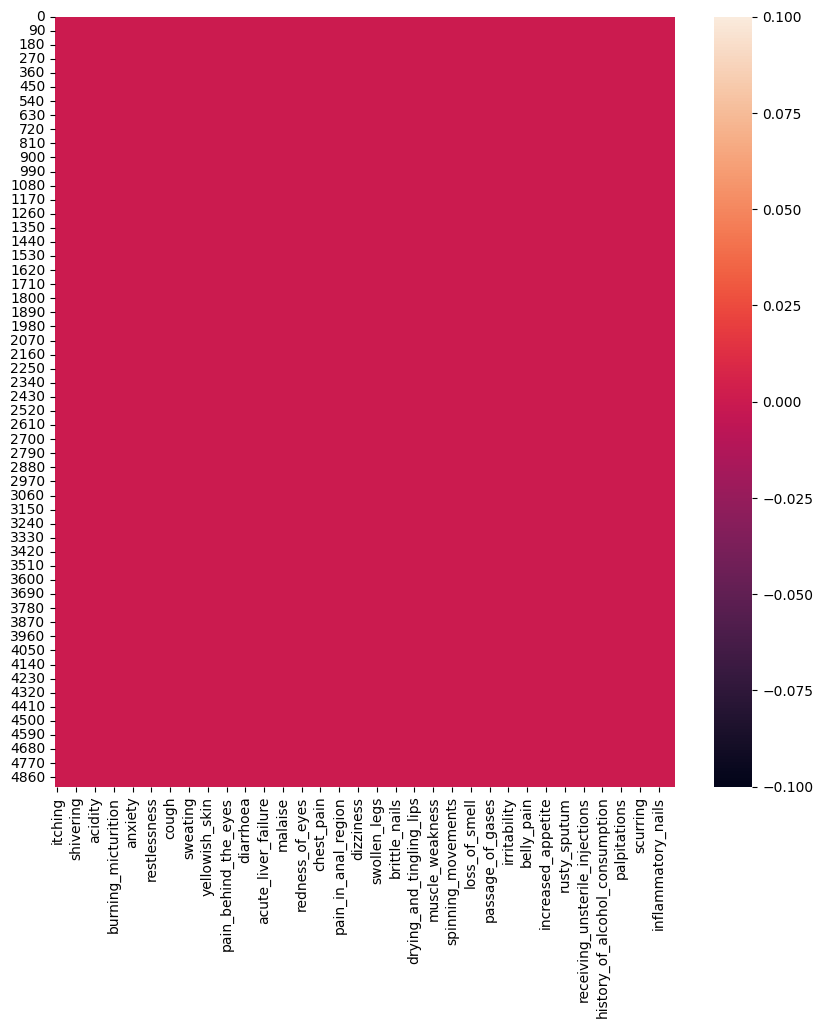

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(X.isnull())

**function for fitting trees of various depths on the training data using cross-validation**

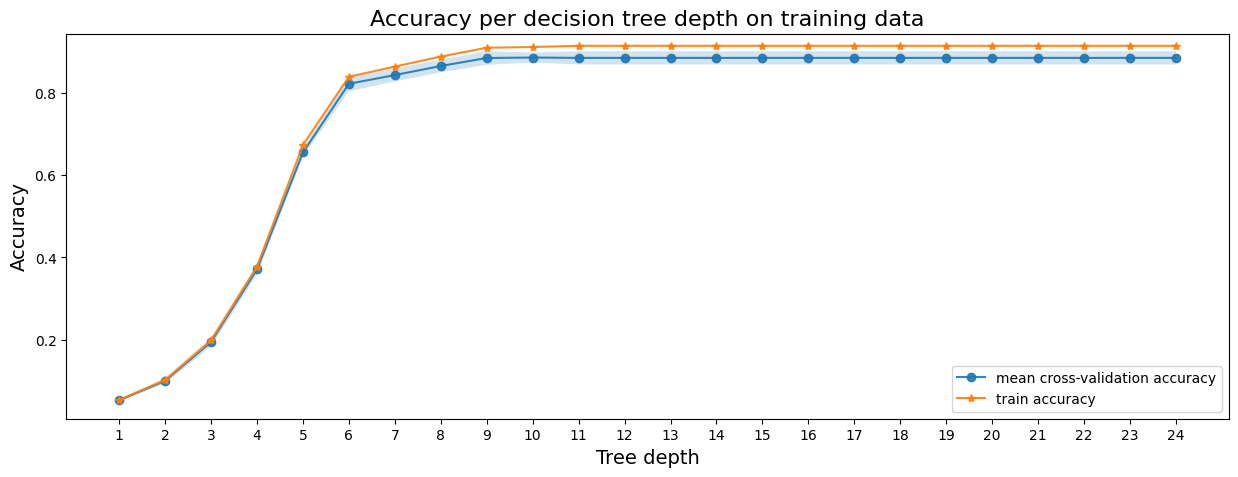

In [21]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth , criterion = "entropy", random_state = 100,
             min_samples_leaf = 24)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(x_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores,
                               'Accuracy per decision tree depth on training data')


In [22]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-10 tree achieves the best mean cross-validation accuracy 88.61794 +/- 0.61198% on training dataset


In [23]:
# function for training and evaluating a tree
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test


# train and evaluate a 5-depth tree
sm_best_tree_accuracy_train, sm_best_tree_accuracy_test = run_single_tree(x_train, y_train,
                                                                          x_test, y_test,
                                                                          sm_best_tree_depth)

Single tree depth:  10
Accuracy, Training Set:  35.07549 %
Accuracy, Test Set:  28.72629 %


# **1st ML Model Training**

In [24]:
# Decision Tree Classifier

dtc_obj  = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
            max_depth = 10, min_samples_leaf = 24)
dtc = dtc_obj.fit(x_train,y_train)

**Score of Trained Model**

In [25]:
dtc.score(x_test,y_test)*100

88.07588075880759

In [26]:
scores = cross_val_score(dtc, x_test, y_test, cv=3)
scores.mean()

0.6476964769647696

**Model Test Pridections**

In [27]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Model Prediction
def get_pridected_value(symptoms_experiance):
  symptoms_dict = {'itching': 0, 'skin_rash': 1, 'nodal_skin_eruptions': 2, 'continuous_sneezing': 3, 'shivering': 4, 'chills': 5, 'joint_pain': 6, 'stomach_pain': 7, 'acidity': 8, 'ulcers_on_tongue': 9, 'muscle_wasting': 10, 'vomiting': 11, 'burning_micturition': 12, 'spotting_ urination': 13, 'fatigue': 14, 'weight_gain': 15, 'anxiety': 16, 'cold_hands_and_feets': 17, 'mood_swings': 18, 'weight_loss': 19, 'restlessness': 20, 'lethargy': 21, 'patches_in_throat': 22, 'irregular_sugar_level': 23, 'cough': 24, 'high_fever': 25, 'sunken_eyes': 26, 'breathlessness': 27, 'sweating': 28, 'dehydration': 29, 'indigestion': 30, 'headache': 31, 'yellowish_skin': 32, 'dark_urine': 33, 'nausea': 34, 'loss_of_appetite': 35, 'pain_behind_the_eyes': 36, 'back_pain': 37, 'constipation': 38, 'abdominal_pain': 39, 'diarrhoea': 40, 'mild_fever': 41, 'yellow_urine': 42, 'yellowing_of_eyes': 43, 'acute_liver_failure': 44, 'fluid_overload': 45, 'swelling_of_stomach': 46, 'swelled_lymph_nodes': 47, 'malaise': 48, 'blurred_and_distorted_vision': 49, 'phlegm': 50, 'throat_irritation': 51, 'redness_of_eyes': 52, 'sinus_pressure': 53, 'runny_nose': 54, 'congestion': 55, 'chest_pain': 56, 'weakness_in_limbs': 57, 'fast_heart_rate': 58, 'pain_during_bowel_movements': 59, 'pain_in_anal_region': 60, 'bloody_stool': 61, 'irritation_in_anus': 62, 'neck_pain': 63, 'dizziness': 64, 'cramps': 65, 'bruising': 66, 'obesity': 67, 'swollen_legs': 68, 'swollen_blood_vessels': 69, 'puffy_face_and_eyes': 70, 'enlarged_thyroid': 71, 'brittle_nails': 72, 'swollen_extremeties': 73, 'excessive_hunger': 74, 'extra_marital_contacts': 75, 'drying_and_tingling_lips': 76, 'slurred_speech': 77, 'knee_pain': 78, 'hip_joint_pain': 79, 'muscle_weakness': 80, 'stiff_neck': 81, 'swelling_joints': 82, 'movement_stiffness': 83, 'spinning_movements': 84, 'loss_of_balance': 85, 'unsteadiness': 86, 'weakness_of_one_body_side': 87, 'loss_of_smell': 88, 'bladder_discomfort': 89, 'foul_smell_of urine': 90, 'continuous_feel_of_urine': 91, 'passage_of_gases': 92, 'internal_itching': 93, 'toxic_look_(typhos)': 94, 'depression': 95, 'irritability': 96, 'muscle_pain': 97, 'altered_sensorium': 98, 'red_spots_over_body': 99, 'belly_pain': 100, 'abnormal_menstruation': 101, 'dischromic _patches': 102, 'watering_from_eyes': 103, 'increased_appetite': 104, 'polyuria': 105, 'family_history': 106, 'mucoid_sputum': 107, 'rusty_sputum': 108, 'lack_of_concentration': 109, 'visual_disturbances': 110, 'receiving_blood_transfusion': 111, 'receiving_unsterile_injections': 112, 'coma': 113, 'stomach_bleeding': 114, 'distention_of_abdomen': 115, 'history_of_alcohol_consumption': 116, 'fluid_overload.1': 117, 'blood_in_sputum': 118, 'prominent_veins_on_calf': 119, 'palpitations': 120, 'painful_walking': 121, 'pus_filled_pimples': 122, 'blackheads': 123, 'scurring': 124, 'skin_peeling': 125, 'silver_like_dusting': 126, 'small_dents_in_nails': 127, 'inflammatory_nails': 128, 'blister': 129, 'red_sore_around_nose': 130, 'yellow_crust_ooze': 131}
  pred_des_list = {15: 'Fungal infection', 4: 'Allergy', 16: 'GERD', 9: 'Chronic cholestasis', 14: 'Drug Reaction', 33: 'Peptic ulcer diseae', 1: 'AIDS', 12: 'Diabetes ', 17: 'Gastroenteritis', 6: 'Bronchial Asthma', 23: 'Hypertension ', 30: 'Migraine', 7: 'Cervical spondylosis', 32: 'Paralysis (brain hemorrhage)', 28: 'Jaundice', 29: 'Malaria', 8: 'Chicken pox', 11: 'Dengue', 37: 'Typhoid', 40: 'hepatitis A', 19: 'Hepatitis B', 20: 'Hepatitis C', 21: 'Hepatitis D', 22: 'Hepatitis E', 3: 'Alcoholic hepatitis', 36: 'Tuberculosis', 10: 'Common Cold', 34: 'Pneumonia', 13: 'Dimorphic hemmorhoids(piles)', 18: 'Heart attack', 39: 'Varicose veins', 26: 'Hypothyroidism', 24: 'Hyperthyroidism', 25: 'Hypoglycemia', 31: 'Osteoarthristis', 5: 'Arthritis', 0: '(vertigo) Paroymsal  Positional Vertigo', 2: 'Acne', 38: 'Urinary tract infection', 35: 'Psoriasis', 27: 'Impetigo'}
  input_vector = np.zeros(len(symptoms_dict))
  for item in symptoms_experiance:
    input_vector[[symptoms_dict[item]]] = 1
  return pred_des_list[dtc.predict([input_vector])[0]]

print(get_pridected_value(['skin_rash', 'high_fever', 'yellow_crust_ooze']))

Fungal infection


**Save Model**

Save Model Using Pickle

In [28]:
import pickle as pk

In [29]:
# pk.dump([dtc,le],open('/content/drive/MyDrive/Project/save_model', 'wb'))

# **2nd ML Model Training**

In [30]:
second_rf_clf = DecisionTreeClassifier()
second_rf_clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [31]:
scores = cross_val_score(second_rf_clf, x_test, y_test, cv=3)
scores.mean()

0.970189701897019

**Model predict**

In [32]:
x_test[:1]

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
4037,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
second_rf_clf.predict(x_test[:1])

array([40])

In [34]:
y_test

array([40,  6, 16, ...,  8, 10, 33])

**Save Model**

In [35]:
# pk.dump(second_rf_clf,open('/content/drive/MyDrive/Project/second_model', 'wb'))

# **3rd NLTK Model**

**Imports**

In [36]:
import spacy
import nltk

**Using Spacy**

Load spacy Pretrained Model

In [37]:
nlp = spacy.load("en_core_web_sm")

Test Pretrained Model

In [38]:
data = '''hey, I am suffering from fever'''

In [39]:
doc = nlp(data)

In [40]:
slem = [token.pos_ for token in nlp(data)]
print(slem)

['INTJ', 'PUNCT', 'PRON', 'AUX', 'VERB', 'ADP', 'NOUN']


In [41]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [42]:
for token in doc:
  print(token ,"|", token.lemma_ , "|" , token.pos_ )

hey | hey | INTJ
, | , | PUNCT
I | I | PRON
am | be | AUX
suffering | suffer | VERB
from | from | ADP
fever | fever | NOUN


**Used Hugging Face Model**

In [43]:
# pip install transformers

Using Hugging face model to detect disease from the given sentence

In [44]:
from transformers import pipeline

# Test 1
# PRETRAINED = "drAbreu/bioBERT-NER-NCBI_disease"
# ner0 = pipeline(task="ner",model=PRETRAINED, tokenizer=PRETRAINED)

# test 2
# PRETRAINED = "alvaroalon2/biobert_diseases_ner"
# ner1 = pipeline(task="ner",model=PRETRAINED, tokenizer=PRETRAINED)

# Test 3
# PRETRAINED = "bioformers/bioformer-cased-v1.0-ncbi-disease"
# ner2 = pipeline(task="ner",model=PRETRAINED, tokenizer=PRETRAINED)

# test 3
# PRETRAINED = "datummd/NCBI_BC5CDR_disease"
# ner3 = pipeline(task="ner",model=PRETRAINED, tokenizer=PRETRAINED)

# test 4
PRETRAINED = "raynardj/ner-disease-ncbi-bionlp-bc5cdr-pubmed"
ner = pipeline(task="ner",model=PRETRAINED, tokenizer=PRETRAINED)



config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

**test Model**

In [45]:
text_data = "hey, I am suffering from fever"
ner(text_data, aggregation_strategy="first")

[{'entity_group': 'Disease',
  'score': 0.69358975,
  'word': ' fever',
  'start': 25,
  'end': 30}]

**Save Model for reuse**

In [46]:
# pk.dump( ner,open('/content/drive/MyDrive/Project/ner_model', 'wb'))

In [49]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [50]:
import nltk
nltk.download('punkt')

def tokenize(pattern):
    return nltk.word_tokenize(pattern)

# Example usage
for pattern in intent['patterns']:
    w = tokenize(pattern)
    all_words.extend(w)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **4th NN Model Training**

In [51]:
stemmer = PorterStemmer()

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end

        return out

def tokenize(sentence):
    """
    split sentence into array of words/tokens
    a token can be a word or punctuation character, or number
    """
    return nltk.word_tokenize(sentence)


def stem(word):
    """
    stemming = find the root form of the word
    examples:
    words = ["organize", "organizes", "organizing"]
    words = [stem(w) for w in words]
    -> ["organ", "organ", "organ"]
    """
    return stemmer.stem(word.lower())


def bag_of_words(tokenized_sentence, words):
    """
    return bag of words array:
    1 for each known word that exists in the sentence, 0 otherwise
    example:
    sentence = ["hello", "how", "are", "you"]
    words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
    bog   = [  0 ,    1 ,    0 ,   1 ,    0 ,    0 ,      0]
    """
    # stem each word
    sentence_words = [stem(word) for word in tokenized_sentence]
    # initialize bag with 0 for each word
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words:
            bag[idx] = 1

    return bag


with open('/content/intents.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))


# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)

        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}


# Save Model
# FILE = "/content/drive/MyDrive/Project/data.pth"
# torch.save(data, FILE)

print(f'training complete. file saved')


121 31
Epoch [100/1000], Loss: 1.5536
Epoch [200/1000], Loss: 0.1704
Epoch [300/1000], Loss: 0.0405
Epoch [400/1000], Loss: 0.0078
Epoch [500/1000], Loss: 0.0084
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0028
Epoch [800/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0018
Epoch [1000/1000], Loss: 0.0000
final loss: 0.0000
training complete. file saved
